In [236]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import seaborn as sns
import pymc as pm
import seaborn as sns
sns.set()





# Introduction

This python notebook works through a tutorial of how to perform hierachical bayesian analysis on cricket data. One of the teams i've played for in the past is Quokkas CC: http://quokkascc.com//.  Quokkas are a global cricket franchise playing across multiple formats, one core format is the LMS (T20). One of the good aspects of LMS is the richness of the source of data, therefore presents itself as a perfect repository to perform data analysis on.

The data we're going to be accessing is the batsman score per innings in a game, which also contains other information about their innings. The overall mission of the notebook is to find the overall probability of a player converting a score to a 50. However this problem can be generalised to any context when analysing conversions, e.g website conversions.

## Webscraping

The first step is to access all the data required. For this I use a simple webscraper, BeautifulSoup. The function I've created takes a list of links and then extracts out the scorecard information for the team. The links can be replaced (to your own team) or additonal links can be added. 



In [237]:
def scrape_scorecard(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table that contains the data we want to extract
    table = soup.find("table")

    # Extract the rows of the table
    rows = table.find_all("tr")

    # Initialize an empty list to store the data
    data = []

    # Loop through each row in the table
    for row in rows:
        # Extract the cells of the row
        cells = row.find_all("td")

        # Initialize an empty list to store the data for this row
        row_data = []

        # Loop through each cell in the row
        for cell in cells:
            # Extract the text from the cell and add it to the row data
            row_data.append(cell.text.strip())

        # If the row data contains the word "Extras", stop adding data to the list
        if "Extras" in row_data:
            break

        # Add the row data to the list of all data
        data.append(row_data)

    # Create a pandas dataframe from the extracted data
    df = pd.DataFrame(data, columns=["Batsmen", "Runs", "Balls", "4s", "6s", "SR"])

    # Remove any rows that have missing data
    df = df.dropna()

    return df

# Example list of links
links = [
    "https://www.lastmanstands.com/leagues/scorecard/2nd-innings?fixtureid=360720",
    "https://www.lastmanstands.com/leagues/scorecard/1st-innings?fixtureid=360715",
    "https://www.lastmanstands.com/leagues/scorecard/1st-innings?fixtureid=345371",
    "https://www.lastmanstands.com/leagues/scorecard/2nd-innings?fixtureid=345387",
    "https://www.lastmanstands.com/leagues/scorecard/2nd-innings?fixtureid=345384",
    "https://www.lastmanstands.com/leagues/scorecard/2nd-innings?fixtureid=345382",
    "https://www.lastmanstands.com/leagues/scorecard/2nd-innings?fixtureid=345379",
    "https://www.lastmanstands.com/leagues/scorecard/1st-innings?fixtureid=345372",
    "https://www.lastmanstands.com/leagues/scorecard/1st-innings?fixtureid=362043",
    "https://www.lastmanstands.com/leagues/scorecard/1st-innings?fixtureid=309963",
    "https://www.lastmanstands.com/leagues/scorecard/2nd-innings?fixtureid=309938",
    "https://www.lastmanstands.com/leagues/scorecard/2nd-innings?fixtureid=309960",
    "https://www.lastmanstands.com/leagues/scorecard/2nd-innings?fixtureid=309958",
    "https://www.lastmanstands.com/leagues/scorecard/2nd-innings?fixtureid=309946",
    "https://www.lastmanstands.com/leagues/scorecard/2nd-innings?fixtureid=309943",
    "https://www.lastmanstands.com/leagues/scorecard/2nd-innings?fixtureid=309939",
    "https://www.lastmanstands.com/leagues/scorecard/1st-innings?fixtureid=291434",
    "https://www.lastmanstands.com/leagues/scorecard/1st-innings?fixtureid=291430",
    "https://www.lastmanstands.com/leagues/scorecard/1st-innings?fixtureid=291429",
    "https://www.lastmanstands.com/leagues/scorecard/2nd-innings?fixtureid=248218",
    "https://www.lastmanstands.com/leagues/scorecard/2nd-innings?fixtureid=248235",
    "https://www.lastmanstands.com/leagues/scorecard/1st-innings?fixtureid=248238",
    "https://www.lastmanstands.com/leagues/scorecard/1st-innings?fixtureid=248214",
    "https://www.lastmanstands.com/leagues/scorecard/2nd-innings?fixtureid=248228",
    "https://www.lastmanstands.com/leagues/scorecard/2nd-innings?fixtureid=248225",
    "https://www.lastmanstands.com/leagues/scorecard/1st-innings?fixtureid=248213"
    
]

# Create an empty list to store the dataframes
df_list = []

# Loop through each link in the list
for link in links:
    # Scrape the data from each link and add it to the list of dataframes
    df_list.append(scrape_scorecard(link))

# Concatenate all of the dataframes into one large dataframe
df = pd.concat(df_list)

print(df)


                   Batsmen Runs Balls 4s 6s      SR
1       Alan ElliottCaught    1     2  0  0   50.00
2     Charan LochanNot Out   50    22  8  0  227.27
3     Jared FagbergNot Out   43    24  5  1  179.17
4   Scott LearmonthNot Out   24    15  3  0  160.00
1     Jamie BaldwinNot Out   53    24  5  2  220.83
..                     ...  ...   ... .. ..     ...
4          Seil SongCaught   31    22        140.91
5       Alan ElliottBowled   19    26         73.08
6        Tridib DasNot Out    6     7         85.71
7          Dave BarnettLBW    1     2         50.00
8     Robin BradleyNot Out    1     2         50.00

[184 rows x 6 columns]


## Data Cleaning

The data has come out pretty well, although there are some issues in the Batsmen column. The method of dismissal has been included in the column. Therefore this will require some maniupliation to clean the data. For simplicity of following this tutorial, i've also excluded any players which have played less than 3 games.

A nuance of the LMS league is that you have to retire at 50. You are able to come back in, after all players are out. Therefore we see a modal score of 50, then some scores appear after this where players have been able to come back in.

In [238]:
df['Dismissal'] = df['Batsmen'].str.extract(r'(Bowled|Caught|LBW|Not Out|Run Out|Stumped)', expand=False)
df['Batsmen'] = df['Batsmen'].str.replace(r'(Bowled|Caught|LBW|Not Out|Run Out|Stumped)', '')

# Convert columns to integers
df['Runs'] = df['Runs'].astype(int)
df['Balls'] = df['Balls'].astype(int)


value_counts = df['Batsmen'].value_counts()
df = df[df['Batsmen'].isin(value_counts[value_counts >= 4].index)].reset_index().rename(columns={"index": "batting number"})


C:\Users\Niall\AppData\Local\Temp\ipykernel_61056\2637161475.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Batsmen'] = df['Batsmen'].str.replace(r'(Bowled|Caught|LBW|Not Out|Run Out|Stumped)', '')


## Charting & EDA

Plotting the histogram of runs scored, you can see the big modal spike at 50, then a small number of innings after this point. This is essentially a semi-censoring issue, we would have expected players at 50 to reach a higher score

Text(0, 0.5, 'Number of Occurances')

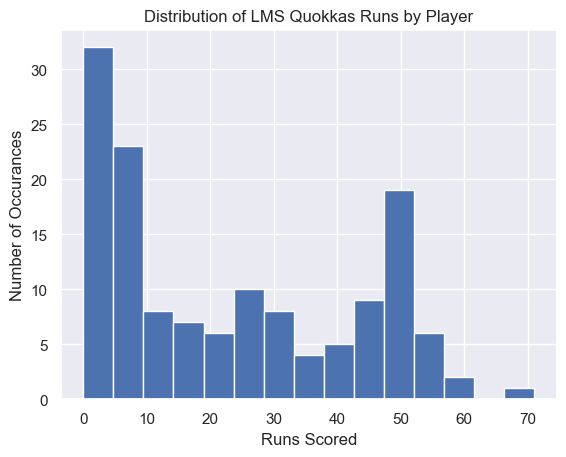

In [239]:
#Plotting a histogram of the runs scored
plt.hist(df["Runs"].values.astype(int),bins=15, cumulative=False);
plt.title("Distribution of LMS Quokkas Runs by Player")
plt.xlabel("Runs Scored")
plt.ylabel("Number of Occurances")


# Truncating the data

In my first analysis, i'm only interested in the first innings score. In later tutorials, i will work in some methods we can account for the censored data issue. Therefore any observations over 50, I will truncate and recode the score as 50.

In [240]:
df['Runs'] = np.where(df['Runs'] > 50, 50, df['Runs'])


Text(0, 0.5, 'Number of Occurances')

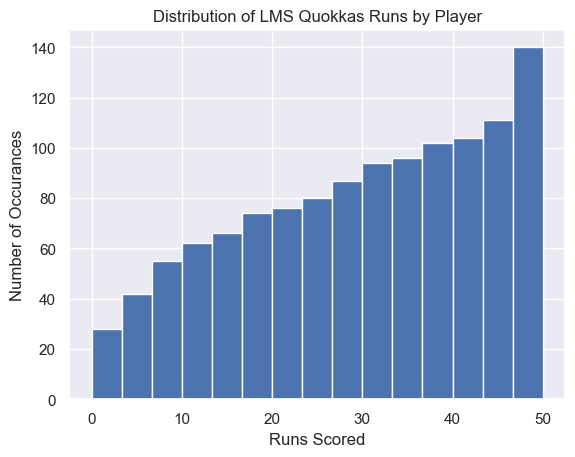

In [241]:
#Plotting a histogram of the runs scored
plt.hist(df["Runs"].values.astype(int),bins=15, cumulative=True);
plt.title("Distribution of LMS Quokkas Runs by Player")
plt.xlabel("Runs Scored")
plt.ylabel("Number of Occurances")

## Heteroscedasicity of the data

It's also interesting to look at the relationship between the number of runs and balls. As we can see the level of heteroscedasdicity of runs increases as the number of balls increases. If this was of interest, there are other statistical techniques we can use to control for this.

I've included a dotted line where the data has now been truncated at 50

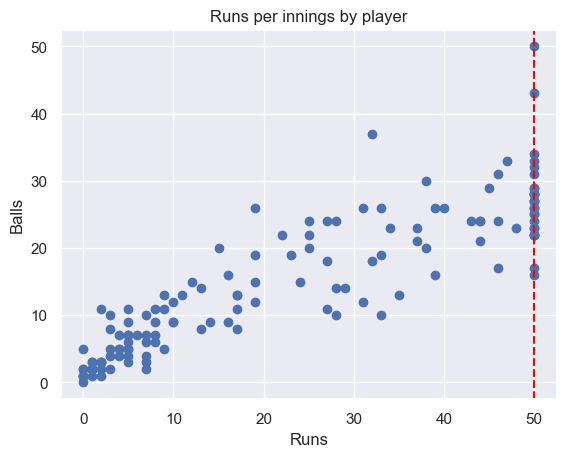

In [242]:
# Convert columns to integers
df['Runs'] = df['Runs'].astype(int)
df['Balls'] = df['Balls'].astype(int)

plt.scatter(df['Runs'], df['Balls'])
plt.axvline(x=50, linestyle='--', color='red')
plt.title("Runs per innings by player")
plt.xlabel('Runs')
plt.ylabel('Balls')
plt.show()

## Methods of dismissal

Exploring the method of dismissal on this chart is of interest too. We can see that generally there is a higher occurance of LBW & bowled early in batters innings. This potentially suggests that players of lower ability score less and are more prone to these types of dismissals. Whereas more established batters are often out caught. 

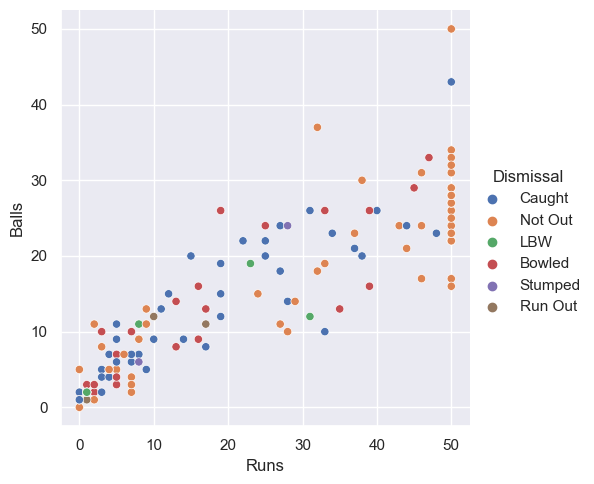

In [243]:
sns.relplot(data=df, x="Runs", y="Balls", hue="Dismissal")

## Data EDA

In addtion to graphical EDA. We can do some calculations on the data to draw out any more insights.

### Most common form of dismissal (including not outs)

In [244]:
# Mode of dismissal for each player
mode_of_dismissal = df.groupby('Batsmen')['Dismissal'].agg(lambda x: x.value_counts().index[0])
print("Mode of Dismissal for each player: \n", mode_of_dismissal)

Mode of Dismissal for each player: 
 Batsmen
Alan Elliott           Not Out
Charan Lochan           Caught
Dave Barlow            Not Out
Dave Barnett           Not Out
David Cosway            Bowled
Guy Walker             Not Out
Herculano Rodrigues     Caught
Jared Fagberg           Caught
Laurence Williams      Not Out
Loughlin Magowan        Bowled
Scott Learmonth        Not Out
Sohail Abdi             Bowled
Tridib Das             Not Out
Name: Dismissal, dtype: object


### Most common dismissal (excluding not outs)

In [245]:
#Most Common Dismissal ignoring Not Outs
mode_of_dismissal = df.loc[df["Dismissal"] != "Not Out"].groupby("Batsmen")["Dismissal"].agg(lambda x: x.value_counts().index[0])
print("Most Common Dismissal for each player ignoring Not Outs: \n", mode_of_dismissal)

Most Common Dismissal for each player ignoring Not Outs: 
 Batsmen
Alan Elliott            Caught
Charan Lochan           Caught
Dave Barlow             Caught
Dave Barnett            Caught
David Cosway            Bowled
Guy Walker             Run Out
Herculano Rodrigues     Caught
Jared Fagberg           Caught
Laurence Williams       Bowled
Loughlin Magowan        Bowled
Scott Learmonth         Bowled
Sohail Abdi             Bowled
Tridib Das              Caught
Name: Dismissal, dtype: object


### Quickest 50 scored (Each innings is 100 balls and 60 minutes long)

In [246]:
# Top 10 quickest 50s
df['Minutes'] = df['Balls'] * 0.6
df['Fifty'] = np.where(df['Runs'] >= 50, True, False)
top_10_quickest_50s = df.loc[df['Fifty'] == True].sort_values(by='Minutes').head(10)
print("Top 10 Quickest 50s: \n", top_10_quickest_50s[['Batsmen', 'Minutes']])

Top 10 Quickest 50s: 
                Batsmen  Minutes
132      Jared Fagberg      9.6
8    Laurence Williams     10.2
31   Laurence Williams     13.2
28     Scott Learmonth     13.2
1        Charan Lochan     13.2
6           Guy Walker     13.2
98     Scott Learmonth     13.8
71       Charan Lochan     13.8
68       Charan Lochan     14.4
4          Dave Barlow     15.0


### Slowest strike-rate in an innings (more than 15 balls)

In [247]:
# 10 innings with slowest strike rate (faced more than 10 balls)
df['Strike Rate'] = df['Runs'] / df['Balls'] * 100
slow_strike_rate = df.loc[(df['Balls'] >= 15) & (df['Strike Rate'] < 120)].sort_values(by='Strike Rate').head(10)
print("10 Innings with Slowest Strike Rate (faced more than 10 balls): \n", slow_strike_rate[['Batsmen', 'Strike Rate']])

10 Innings with Slowest Strike Rate (faced more than 10 balls): 
                  Batsmen  Strike Rate
137         Alan Elliott    73.076923
67   Herculano Rodrigues    75.000000
94          Alan Elliott    80.000000
110           Tridib Das    86.486486
39          Alan Elliott   100.000000
84         Charan Lochan   100.000000
85          Alan Elliott   100.000000
136        Jared Fagberg   100.000000
135      Scott Learmonth   104.166667
21          Alan Elliott   112.500000


### Average number of runs per dismissal type

In [248]:
# Find the average number of runs per dismissal for each player
average_runs_per_dismissal = df.groupby(['Batsmen', 'Dismissal'])['Runs'].mean().reset_index()
print("Average Runs per Dismissal for each player: \n", average_runs_per_dismissal)

Average Runs per Dismissal for each player: 
                 Batsmen Dismissal       Runs
0          Alan Elliott    Bowled  26.000000
1          Alan Elliott    Caught  12.250000
2          Alan Elliott       LBW   2.000000
3          Alan Elliott   Not Out  27.600000
4          Alan Elliott   Stumped  28.000000
5         Charan Lochan    Bowled  10.500000
6         Charan Lochan    Caught  34.750000
7         Charan Lochan       LBW   0.000000
8         Charan Lochan   Not Out  50.000000
9           Dave Barlow    Bowled  16.333333
10          Dave Barlow    Caught   6.333333
11          Dave Barlow   Not Out  33.000000
12          Dave Barlow   Run Out  10.000000
13         Dave Barnett    Bowled  16.000000
14         Dave Barnett    Caught  17.000000
15         Dave Barnett       LBW   1.000000
16         Dave Barnett   Not Out  20.250000
17         David Cosway    Bowled   3.666667
18         David Cosway   Not Out   2.000000
19         David Cosway   Stumped   8.000000
20       

### Number of times each player has been dismissed for each dismissal type

In [249]:
#Find the number of times each player has been dismissed for each mode of dismissal
dismissal_count = df.groupby(['Batsmen', 'Dismissal']).size().reset_index(name='Count')
print("Count of Dismissals for each player: \n", dismissal_count)


Count of Dismissals for each player: 
                 Batsmen Dismissal  Count
0          Alan Elliott    Bowled      2
1          Alan Elliott    Caught      8
2          Alan Elliott       LBW      1
3          Alan Elliott   Not Out     10
4          Alan Elliott   Stumped      1
5         Charan Lochan    Bowled      2
6         Charan Lochan    Caught      8
7         Charan Lochan       LBW      1
8         Charan Lochan   Not Out      7
9           Dave Barlow    Bowled      3
10          Dave Barlow    Caught      3
11          Dave Barlow   Not Out      3
12          Dave Barlow   Run Out      1
13         Dave Barnett    Bowled      1
14         Dave Barnett    Caught      3
15         Dave Barnett       LBW      1
16         Dave Barnett   Not Out      4
17         David Cosway    Bowled      3
18         David Cosway   Not Out      1
19         David Cosway   Stumped      1
20           Guy Walker   Not Out      4
21           Guy Walker   Run Out      1
22  Herculano Rodr

### Percentage of innings a player has hit 50

In [250]:
#% Innings player hits 50
player_50s = df.groupby('Batsmen')['Fifty'].sum()
player_innings = df.groupby('Batsmen').size()
percent_innings_50 = (player_50s / player_innings) * 100
print("Percentage of Innings player has hit a 50: \n", percent_innings_50)

Percentage of Innings player has hit a 50: 
 Batsmen
Alan Elliott            9.090909
Charan Lochan          44.444444
Dave Barlow            10.000000
Dave Barnett            0.000000
David Cosway            0.000000
Guy Walker             20.000000
Herculano Rodrigues    11.111111
Jared Fagberg          33.333333
Laurence Williams      75.000000
Loughlin Magowan        0.000000
Scott Learmonth        20.000000
Sohail Abdi             0.000000
Tridib Das              0.000000
dtype: float64


### Average minutes per innings by each batter

In [251]:
#Average number of minutes per inning
average_minutes_per_inning = df.groupby('Batsmen')['Minutes'].mean()
print("Average number of minutes per inning: \n", average_minutes_per_inning)

Average number of minutes per inning: 
 Batsmen
Alan Elliott            9.518182
Charan Lochan          12.533333
Dave Barlow             8.220000
Dave Barnett            6.533333
David Cosway            2.400000
Guy Walker              5.640000
Herculano Rodrigues     8.000000
Jared Fagberg           9.571429
Laurence Williams      15.450000
Loughlin Magowan        0.900000
Scott Learmonth        10.950000
Sohail Abdi             3.975000
Tridib Das              9.240000
Name: Minutes, dtype: float64


### Number of innings by batter

In [252]:
df.groupby('Batsmen').size()

Batsmen
Alan Elliott           22
Charan Lochan          18
Dave Barlow            10
Dave Barnett            9
David Cosway            5
Guy Walker              5
Herculano Rodrigues     9
Jared Fagberg          21
Laurence Williams       4
Loughlin Magowan        4
Scott Learmonth        20
Sohail Abdi             8
Tridib Das              5
dtype: int64

### Average runs by batting order and batter

In [253]:
#Average runs at each batting order
average_runs_per_inning = df.groupby(['Batsmen', 'batting number'])['Runs'].mean().reset_index()
print("Average Runs per Inning for each player at each batting position: \n", average_runs_per_inning)


Average Runs per Inning for each player at each batting position: 
                 Batsmen  batting number       Runs
0          Alan Elliott               1  17.000000
1          Alan Elliott               2  27.000000
2          Alan Elliott               3  35.250000
3          Alan Elliott               4  28.000000
4          Alan Elliott               5  18.400000
5          Alan Elliott               6  32.000000
6          Alan Elliott               7  11.333333
7          Alan Elliott               8   7.000000
8         Charan Lochan               1  36.250000
9         Charan Lochan               2  46.571429
10        Charan Lochan               4  16.500000
11        Charan Lochan               5   0.000000
12          Dave Barlow               2  50.000000
13          Dave Barlow               3  45.000000
14          Dave Barlow               4   2.000000
15          Dave Barlow               5  10.000000
16          Dave Barlow               6  18.000000
17          Da

## Interesting aspects to learn from the data

We've run through a lot of descriptive statistics, but within it there are some fascinating features present in the data:

1. Charan is not out in 7 innings, in all of these innings he has gone on to reach 50. This 'game finisher' club is a small one with Herc and Laurence in it. Jared narrowly misses out in this club

2. Jareds most common form of dismissal is caught (10 times), he has only been bowled once and LBW once. His average in this mode of dismissal is 12.2, implying he gets out early through attempting big hits.

3. Alan comes up 4 times out of the 10 slowest innings. However has a consistently good average across all batting positions in the order. Additionally most often achieves a not out in the innings

4. Laurance has a remarkable conversion rate to 50s (75%). However this only in a sample size of 4

5. Not all batters have achieved to score a 50

The last 2 points are interesting aspects i'm going to dig deeper on

## Probability of scoring a 50

The interesting compontent I want to pick up on is an analysis into the player conversion rates to 50. For some players we have a high conversion rate to 50, but a small sample size of innings. For others they have never hit a 50. We may pose the question, what is the true probability of hitting a 50 for each player? We can think this question is analogous to the coin tossing problem. If we toss a coint 4 times and acheive 4 heads. We are unlikely to suggest the coin has a probability of achieving a head 100% of the time.

### Bayesian Model

One way to answer the question is to use a hierachical model. A hierachcial model essentially allows the model to share information across the players, through a shared distbrituion, this is referred to as the global parameter. Players are also able to deviate from this global parameter, with player specific parameters. 

For the probability of hitting a 50, we are going to assume there is are latent distributions which impact the players probability of hitting a 50. These are specified by the alpha and beta parameter, these corresponding parameters have their own global parameter. For players that have few innings, they are more likely to be informed by the global parameters.

The model then takes these variables and transforms them using an inverse logit function. This inverse logit function scales the data between 0 and 1. This can therefore be interpreted as the probability of a player hitting a 50.

A bernoulli distribution is then used. A bernoulli distribution. This is essentially because we can think of the problem being one trial. The player has one innings and either achieves a 50 or doesn't



In [254]:
# Create a list of player names
players = df["Batsmen"].unique()

# Create a mapping from player names to player codes
player_mapping = {player: i for i, player in enumerate(players)}

# Convert player names to player codes
df["Batsmen_code"] = df["Batsmen"].map(player_mapping)

# Create the hierarchical model
with pm.Model() as model:
    # Global alpha and beta parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    
    # Player-specific alpha and beta parameters
    player_alphas = pm.Normal("player_alphas", mu=alpha, sigma=1, shape=len(players))
    player_betas = pm.Normal("player_betas", mu=beta, sigma=1, shape=len(players))

    
    # Calculate player-specific p values
    p = pm.Deterministic("p", pm.math.invlogit(player_alphas[df["Batsmen_code"].values] - player_betas[df["Batsmen_code"].values]))
    
    # Likelihood
    fifty = pm.Bernoulli("fifty", p=p, observed=df["Fifty"].values)
    
    # Sampling
    idata = pm.sample(draws=2000, chains=4)





Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, player_alphas, player_betas]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 48 seconds.


In [255]:
#Specify my own inverse_logit transformation

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

In [256]:
pm.summary(idata, var_names=["alpha","beta", "player_alphas","player_betas"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.482,7.362,-14.251,12.991,0.571,0.404,168.0,222.0,1.04
beta,1.547,7.355,-12.504,14.727,0.571,0.406,167.0,225.0,1.04
player_alphas[0],-0.670,7.392,-15.195,12.214,0.571,0.404,169.0,238.0,1.04
player_alphas[1],0.323,7.396,-13.586,13.887,0.573,0.406,168.0,237.0,1.04
player_alphas[2],0.103,7.391,-14.153,13.293,0.570,0.404,170.0,234.0,1.04
player_alphas[3],-0.253,7.393,-14.367,13.007,0.571,0.404,169.0,233.0,1.04
player_alphas[4],-0.632,7.389,-14.332,13.127,0.568,0.403,170.0,242.0,1.04
player_alphas[5],-0.382,7.418,-14.650,12.837,0.573,0.406,169.0,242.0,1.04
player_alphas[6],-1.021,7.412,-15.335,12.201,0.570,0.404,170.0,236.0,1.04
player_alphas[7],0.531,7.406,-13.724,13.751,0.573,0.406,168.0,236.0,1.04


Inspecting the trace, it looks like there has been inefficient sampling of the posteriors. This can be caused by varialble correlations. Therefore we may want to look at the pair plots of our variables

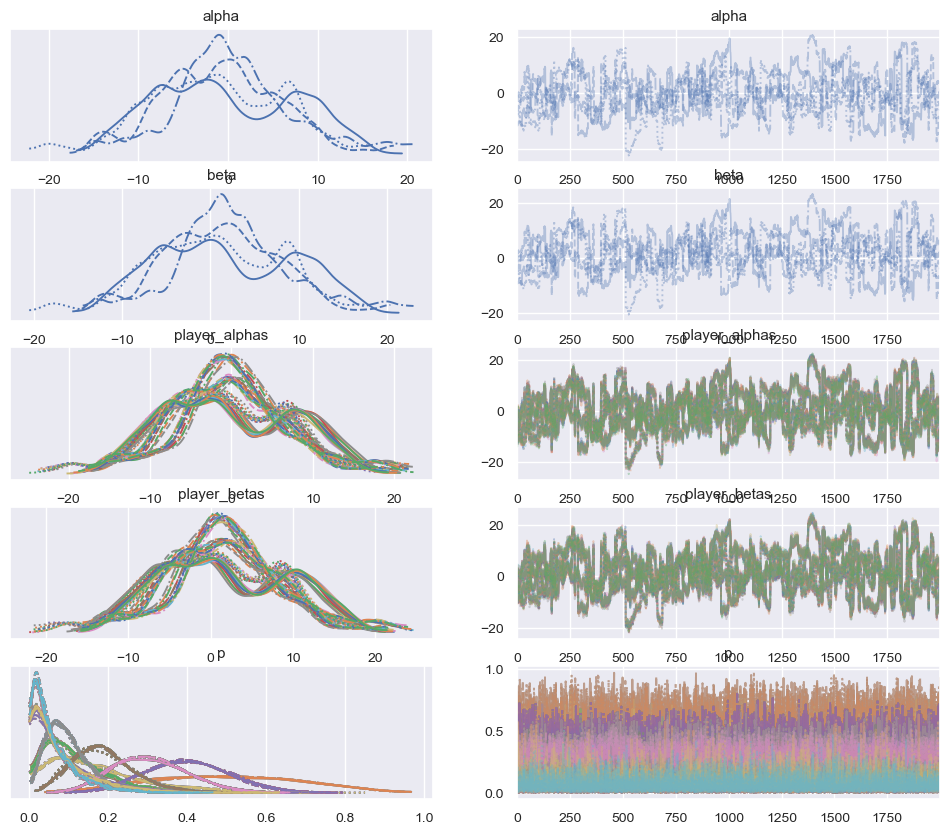

In [257]:
#Inspecting the trace
pm.plot_trace(idata, combined=False);

### Pair Plot

There are near perfect correlations between alpha and beta. Given how the model was specified, this makes sense. Realistically they are both controlling the same thing, therefore we can just remove either the alphas or the betas from the model

<AxesSubplot: xlabel='alpha', ylabel='beta'>

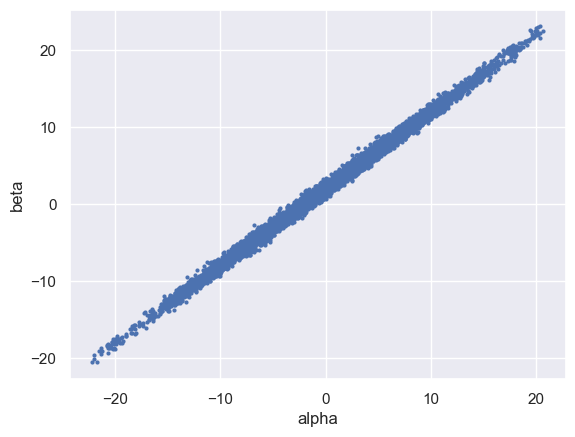

In [258]:
#Plotting correlations between alpha and beta
az.plot_pair(
    idata,
    var_names=["alpha", "beta"]
)

## Re-parametizing the model

For the new model, I have now taken out the beta. I've also respecified the players alpha as a StudentT distribution. That's because I believe there is likely more dispersion in the data, with extremes of players who can consistently hit 50s and ones who cant. The StudentT achieves this as it places more probability in the tails of the distribution.

In [272]:
# Create a list of player names
players = df["Batsmen"].unique()

# Create a mapping from player names to player codes
player_mapping = {player: i for i, player in enumerate(players)}

# Convert player names to player codes
df["Batsmen_code"] = df["Batsmen"].map(player_mapping)

# Create the hierarchical model
with pm.Model() as model:
    # Global alpha and beta parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)

    
    # Player-specific alpha and beta parameters
    player_alphas = pm.StudentT("player_alphas", mu=alpha, nu=1, shape=len(players))

    
    # Calculate player-specific p values
    p = pm.Deterministic("p", pm.math.invlogit(player_alphas[df["Batsmen_code"].values]))
    
    # Likelihood
    fifty = pm.Bernoulli("fifty", p=p, observed=df["Fifty"].values)
    
    # Sampling
    idata = pm.sample(draws=2000, chains=4)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, player_alphas]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 50 seconds.


With the changes to the model, sampling has improved and the r_hats are now all 1

In [273]:
pm.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.914,0.546,-2.915,-0.871,0.008,0.006,4344.0,4806.0,1.00
player_alphas[0],-2.282,0.656,-3.556,-1.150,0.010,0.007,5162.0,3987.0,1.00
player_alphas[1],-0.435,0.501,-1.372,0.497,0.006,0.005,7190.0,4218.0,1.00
player_alphas[2],-0.918,0.472,-1.821,-0.062,0.006,0.005,6679.0,4901.0,1.00
player_alphas[3],-1.580,0.551,-2.631,-0.578,0.007,0.005,6517.0,4461.0,1.00
...,...,...,...,...,...,...,...,...,...
p[135],0.184,0.079,0.053,0.332,0.001,0.001,6517.0,4461.0,1.00
p[136],0.295,0.094,0.134,0.476,0.001,0.001,6679.0,4901.0,1.00
p[137],0.106,0.057,0.012,0.207,0.001,0.001,5162.0,3987.0,1.00
p[138],0.079,0.083,0.000,0.228,0.001,0.001,661.0,231.0,1.01


## Summary of results

Now we have run our model, we can extract the posterior values for the players and calculate the true probability of hitting a 50. You can see for some players there is a large amount of uncertainty. This is due to them not having many innings. The certainty behind their conversion rate will imrpove with the number of innings they play. Additonally, we now have probabilities for players who have never previously hit a 50 too, this is because teh model has shared information across players.

In [274]:
#Calculating the players probability posteriors
posterior_alpha = idata.posterior.mean(dim="chain")["player_alphas"].values
p50_full_sample = pd.DataFrame(inv_logit((posterior_alpha)))*100

# Get the keys of the mapping dictionary
col_names = list(player_mapping.keys())

# Rename the columns using the keys of the mapping dictionary
print("Probability of hitting a 50")
p50_full_sample.columns = col_names
p50_full_sample.describe().applymap("{:.2f}%".format).drop(["count","std"])


Probability of hitting a 50


,Alan Elliott,Charan Lochan,Jared Fagberg,Scott Learmonth,Dave Barlow,Guy Walker,Sohail Abdi,Laurence Williams,Dave Barnett,David Cosway,Herculano Rodrigues,Loughlin Magowan,Tridib Das
mean,9.60%,39.45%,28.78%,17.43%,10.47%,15.50%,2.72%,60.21%,2.00%,4.21%,11.12%,4.55%,4.26%
min,2.73%,18.26%,15.62%,5.53%,1.55%,2.99%,0.00%,20.17%,0.00%,0.00%,1.89%,0.00%,0.00%
25%,7.71%,35.25%,25.43%,14.72%,7.72%,11.21%,0.30%,50.18%,0.01%,0.75%,8.11%,1.11%,0.79%
50%,9.44%,39.23%,28.49%,17.15%,10.11%,14.62%,1.67%,60.83%,0.79%,3.44%,10.77%,3.27%,3.23%
75%,11.25%,43.31%,31.81%,20.10%,12.79%,19.11%,4.33%,69.86%,3.14%,6.47%,13.61%,6.85%,6.68%
max,22.32%,58.62%,45.86%,31.94%,28.89%,44.56%,24.01%,95.30%,16.16%,22.01%,28.71%,29.48%,25.82%
